In [1]:
# See http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.105.1166&rep=rep1&type=pdf for clarification
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class DirichletControlPoint:
    
    def __repr__(self):
        return f'DirichletControlPoint({self.x}, val={self.val})'
    
    def __init__(self, x, val):
        self.x = x
        self.val = val

class TargetPoint:
    
    def __repr__(self):
        return f'TargetPoint({self.x})'
    
    def __init__(self, x):
        self.x = x

In [3]:
square_control_points = []
for i in np.linspace(0, 1, 11):
    square_control_points.append(DirichletControlPoint(x=(0, i), val=0))
for i in np.linspace(0, 1, 11):
    square_control_points.append(DirichletControlPoint(x=(1, i), val=0))
for i in np.linspace(1, 0, 11):
    square_control_points.append(DirichletControlPoint(x=(i, 0), val=0))
for i in np.linspace(0, 1, 11):
    square_control_points.append(DirichletControlPoint(x=(i, 1), val=0))

In [4]:
square_control_points[:5]

[DirichletControlPoint((0, 0.0), val=0),
 DirichletControlPoint((0, 0.1), val=0),
 DirichletControlPoint((0, 0.2), val=0),
 DirichletControlPoint((0, 0.30000000000000004), val=0),
 DirichletControlPoint((0, 0.4), val=0)]

In [5]:
def create_mapping_targets(control_points, center, r=0.5):
    
    # remove the control points that are defined more than once
    coords = set()
    unique = []
    for cp in control_points:
        if cp.x not in coords:
            coords.add(cp.x)
            unique.append(cp)
    
    # sort the control points 'clockwise' (from 0 to -2pi)
    def clockwise(cp):
        return (
            1 if cp.x[1]-center[1] > 0 else -1,
            (cp.x[0]-center[0])/(cp.x[1]-center[1]-1e-8)
        )
    control_points = sorted(unique, key=clockwise)

    # create equally spaced target points
    target_points = [
        TargetPoint( (r*np.cos(theta), r*np.sin(theta)) )
        for theta in -np.linspace(0, 2*np.pi, len(control_points))
    ]
    
    assert len(control_points) == len(target_points)
    return control_points, target_points

In [6]:
control_points, target_points = create_mapping_targets(square_control_points, (0.5, 0.5))

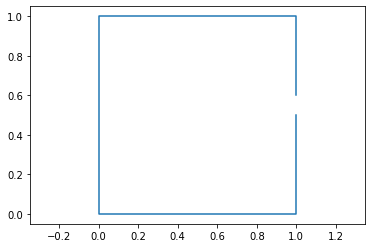

In [7]:
xs = [cp.x[0] for cp in control_points]
ys = [cp.x[1] for cp in control_points]
plt.plot(xs, ys)
plt.axis('equal');

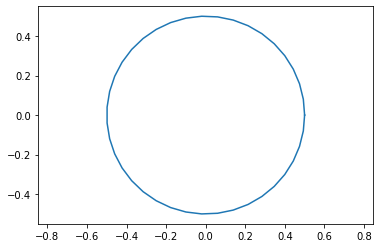

In [8]:
xs = [tp.x[0] for tp in target_points]
ys = [tp.x[1] for tp in target_points]
plt.plot(xs, ys)
plt.axis('equal');

In [9]:
def calc_r_i(x, cp, d=0.01):
    return np.sqrt(
        sum((d_x-d_cp)**2 for d_x, d_cp in zip(x, cp.x)) 
        + d**2
    )

In [10]:
def solve_tps(control_points, targets):
    n_dims = len(control_points[0].x)
    n_pnts = len(control_points)
    n_eqts = n_dims+n_pnts+1
    
    def equation_weights(equation_no):    
        weights = np.zeros(n_eqts)
        if equation_no < n_pnts:
            x = control_points[equation_no].x
            for i in range(n_pnts):
                r_i = calc_r_i(x, control_points[i])
                weights[i] = r_i**2 * np.log(r_i**2)
            weights[n_pnts] = 1.0
            for i in range(n_dims):
                weights[n_pnts+i] = x[i]
        elif equation_no <  n_pnts + n_dims:
            j_dim = equation_no - n_pnts
            for i in range(n_pnts):
                weights[i] = control_points[i].x[j_dim]
        elif equation_no == n_pnts + n_dims:
            weights[:n_pnts] = 1.0
        return weights
    
    W = np.zeros((n_eqts, n_eqts))
    for equation_no in range(n_eqts):
        W[equation_no] = equation_weights(equation_no)
    b = np.zeros(n_eqts)
    b[:n_pnts] = targets
    return np.linalg.solve(W, b)

In [11]:
solve_tps(control_points, np.array([tp.x[0] for tp in target_points]))

LinAlgError: Singular matrix